In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import StableDiffusionPipeline
import warnings
warnings.filterwarnings('ignore')

class DiffusionEmbeddingAnalyser:
    def __init__(self, model_name="runwayml/stable-diffusion-v1-5"):
        """
        Initialize the analyser with a diffusion model.
        
        Args:
            model_name: HuggingFace model identifier for the diffusion model
        """
        print(f"Loading model: {model_name}")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load the pipeline to get the text encoder
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            safety_checker=None,
            requires_safety_checker=False
        )
        
        # Extract text encoder and tokenizer
        self.text_encoder = self.pipe.text_encoder.to(self.device)
        self.tokenizer = self.pipe.tokenizer
        
        print(f"Model loaded on device: {self.device}")
        
    def get_text_embeddings(self, texts):
        """
        Extract text embeddings for a list of text prompts.
        
        Args:
            texts: List of text strings to encode
            
        Returns:
            numpy array of embeddings
        """
        embeddings = []
        
        with torch.no_grad():
            for text in texts:
                # Tokenize text
                tokens = self.tokenizer(
                    text,
                    padding="max_length",
                    max_length=77,  # CLIP's max length
                    truncation=True,
                    return_tensors="pt"
                ).input_ids.to(self.device)
                
                # Get embeddings
                embedding = self.text_encoder(tokens)[0]
                # Use the [EOS] token embedding or mean pooling
                embedding = embedding.mean(dim=1)  # Mean pooling
                embeddings.append(embedding.cpu().numpy())
        
        return np.vstack(embeddings)
    
    def analyse_concept_similarity(self, concept_groups):
        """
        Analyse similarity between different concept groups.
        
        Args:
            concept_groups: Dictionary where keys are category names and values are lists of related concepts
            
        Returns:
            Dictionary containing analysis results
        """
        all_concepts = []
        concept_labels = []
        category_labels = []
        
        # Flatten all concepts and create labels
        for category, concepts in concept_groups.items():
            all_concepts.extend(concepts)
            concept_labels.extend(concepts)
            category_labels.extend([category] * len(concepts))
        
        print(f"Analyzing {len(all_concepts)} concepts across {len(concept_groups)} categories...")
        
        # Get embeddings for all concepts
        embeddings = self.get_text_embeddings(all_concepts)
        
        # Calculate cosine similarity matrix
        similarity_matrix = cosine_similarity(embeddings)
        distance_matrix = euclidean_distances(embeddings)
        distance_matrix = np.sqrt(distance_matrix)  # Convert to distance
        self.distance_matrix = distance_matrix
        
        return {
            'embeddings': embeddings,
            'similarity_matrix': similarity_matrix,
            'concept_labels': concept_labels,
            'category_labels': category_labels,
            'concept_groups': concept_groups,
            'distance_matrix': distance_matrix
        }
    
    def visualise_similarity_matrix(self, results, figsize=(15, 12)):
        """
        Create a heatmap of the similarity matrix.
        """
        plt.figure(figsize=figsize)
        
        # Create color map for categories
        unique_categories = list(set(results['category_labels']))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
        color_map = {cat: colors[i] for i, cat in enumerate(unique_categories)}

        # Create heatmap
        ax = sns.heatmap(
            results['similarity_matrix'],
            xticklabels=results['concept_labels'],
            yticklabels=results['concept_labels'],
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'label': 'Cosine Similarity'}
        )

        # Color the x-axis labels
        xlabels = ax.get_xticklabels()
        for i, label in enumerate(xlabels):
            category = results['category_labels'][i]
            label.set_color(color_map[category])
            label.set_weight('bold')
            label.set_path_effects([
                plt.matplotlib.patheffects.Stroke(linewidth=2, foreground='black'),
                plt.matplotlib.patheffects.Normal()
            ])
        # Color the y-axis labels
        ylabels = ax.get_yticklabels()
        for i, label in enumerate(ylabels):
            category = results['category_labels'][i]
            label.set_color(color_map[category])
            label.set_weight('bold')
            label.set_path_effects([
                plt.matplotlib.patheffects.Stroke(linewidth=2, foreground='black'),
                plt.matplotlib.patheffects.Normal()
            ])

        # Add legend for categories
        legend_elements = [Patch(facecolor=color_map[cat], label=cat) for cat in unique_categories]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.15, 1), loc='upper left')

        plt.title('Text Embedding Similarity Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def visualise_distance_matrix(self, results, figsize=(15, 12)):
        """
        Create a heatmap of the distance matrix with color-coded labels by category.
        """
        plt.figure(figsize=figsize)

        # Create color map for categories
        unique_categories = list(set(results['category_labels']))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
        color_map = {cat: colors[i] for i, cat in enumerate(unique_categories)}

        # Create heatmap
        ax = sns.heatmap(
            results['distance_matrix'],
            xticklabels=results['concept_labels'],
            yticklabels=results['concept_labels'],
            cmap='Reds_r',
            center=0,
            square=True,
            cbar_kws={'label': 'Euclidean Distance'}
        )
        
        # Color the x-axis labels
        xlabels = ax.get_xticklabels()
        for i, label in enumerate(xlabels):
            category = results['category_labels'][i]
            label.set_color(color_map[category])
            label.set_weight('bold')
            label.set_path_effects([
                plt.matplotlib.patheffects.Stroke(linewidth=2, foreground='black'),
                plt.matplotlib.patheffects.Normal()
            ])
        
        # Color the y-axis labels
        ylabels = ax.get_yticklabels()
        for i, label in enumerate(ylabels):
            category = results['category_labels'][i]
            label.set_color(color_map[category])
            label.set_weight('bold')
            label.set_path_effects([
                plt.matplotlib.patheffects.Stroke(linewidth=2, foreground='black'),
                plt.matplotlib.patheffects.Normal()
            ])

        # Add legend for categories
        legend_elements = [Patch(facecolor=color_map[cat], label=cat) for cat in unique_categories]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.15, 1), loc='upper left')

        plt.title('Text Embedding Distance Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def visualise_embeddings_2d(self, results, method='tsne', figsize=(14, 10)):
        """
        Visualise embeddings in 2D using dimensionality reduction.
        
        Args:
            results: Results from analyse_concept_similarity
            method: 'tsne' or 'pca'
        """
        embeddings = results['embeddings']
        
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
            embeddings_2d = reducer.fit_transform(embeddings)
            title = 't-SNE Visualization of Text Embeddings'
        else:
            reducer = PCA(n_components=2, random_state=42)
            embeddings_2d = reducer.fit_transform(embeddings)
            title = 'PCA Visualization of Text Embeddings'
        
        plt.figure(figsize=figsize)
        
        # Create colour map for categories
        unique_categories = list(set(results['category_labels']))
        colours = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
        colour_map = {cat: colours[i] for i, cat in enumerate(unique_categories)}

        # Plot points
        for i, (concept, category) in enumerate(zip(results['concept_labels'], results['category_labels'])):
            plt.scatter(
                embeddings_2d[i, 0], 
                embeddings_2d[i, 1], 
                c=[colour_map[category]], 
                s=100, 
                alpha=0.7,
                label=category if category not in plt.gca().get_legend_handles_labels()[1] else ""
            )
            plt.annotate(concept, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    def calculate_intra_inter_category_similarity(self, results):
        """
        Calculate average similarity within categories vs between categories.
        """
        similarity_matrix = results['similarity_matrix']
        distance_matrix = results['distance_matrix']
        category_labels = results['category_labels']
        concept_groups = results['concept_groups']
        
        intra_similarities = []
        inter_similarities = []
        intra_distances = []
        inter_distances = []

        for i in range(len(category_labels)):
            for j in range(i+1, len(category_labels)):
                sim_value = similarity_matrix[i, j]
                dist_value = distance_matrix[i, j]
                
                if category_labels[i] == category_labels[j]:
                    intra_similarities.append(sim_value)
                    intra_distances.append(dist_value)
                else:
                    inter_similarities.append(sim_value)
                    inter_distances.append(dist_value)
        
        results_summary = {
            'intra_category_mean': np.mean(intra_similarities) if intra_similarities else 0,
            'intra_category_std': np.std(intra_similarities) if intra_similarities else 0,
            'inter_category_mean': np.mean(inter_similarities) if inter_similarities else 0,
            'inter_category_std': np.std(inter_similarities) if inter_similarities else 0,
            'intra_similarities': intra_similarities,
            'inter_similarities': inter_similarities,
            'intra_distances': intra_distances,
            'inter_distances': inter_distances,
            'intra_distance_mean': np.mean(intra_distances) if intra_distances else 0,
            'intra_distance_std': np.std(intra_distances) if intra_distances else 0,
            'inter_distance_mean': np.mean(inter_distances) if inter_distances else 0,
            'inter_distance_std': np.std(inter_distances) if inter_distances else 0
        }
        
        return results_summary
    
    def print_similarity_analysis(self, results):
        """
        Print detailed similarity analysis.
        """
        similarity_stats = self.calculate_intra_inter_category_similarity(results)
        
        print("\n" + "="*60)
        print("SIMILARITY ANALYSIS RESULTS")
        print("="*60)
        
        print(f"\nIntra-category similarity (same category):")
        print(f"  Mean: {similarity_stats['intra_category_mean']:.4f}")
        print(f"  Std:  {similarity_stats['intra_category_std']:.4f}")
        
        print(f"\nInter-category similarity (different categories):")
        print(f"  Mean: {similarity_stats['inter_category_mean']:.4f}")
        print(f"  Std:  {similarity_stats['inter_category_std']:.4f}")
        
        difference = similarity_stats['intra_category_mean'] - similarity_stats['inter_category_mean']
        print(f"\nDifference (intra - inter): {difference:.4f}")
        
        if difference > 0:
            print("✓ Good semantic clustering: Similar concepts are more similar than different concepts")
        else:
            print("⚠ Poor semantic clustering: Similar concepts are not more similar than different concepts")

        print("\nDistance Statistics")
        print(f"Intra-category distance (same category):")
        print(f"  Mean: {similarity_stats['intra_distance_mean']:.4f}")
        print(f"  Std:  {similarity_stats['intra_distance_std']:.4f}")

        print(f"\nInter-category distance (different categories):")
        print(f"  Mean: {similarity_stats['inter_distance_mean']:.4f}")
        print(f"  Std:  {similarity_stats['inter_distance_std']:.4f}")
        difference_distance = similarity_stats['intra_distance_mean'] - similarity_stats['inter_distance_mean']
        print(f"\nDifference (intra - inter): {difference_distance:.4f}")

        # most and least similar pairs
        similarity_matrix = results['similarity_matrix']
        distance_matrix = results['distance_matrix']
        concept_labels = results['concept_labels']
        
        # Get upper triangle indices (avoid diagonal and duplicates)
        triu_indices = np.triu_indices_from(similarity_matrix, k=1)
        similarities = similarity_matrix[triu_indices]
        distances = distance_matrix[triu_indices]
        
        max_idx = np.argmax(similarities)
        min_idx = np.argmin(similarities)
        max_dist_idx = np.argmax(distances)
        min_dist_idx = np.argmin(distances)

        max_pair = (triu_indices[0][max_idx], triu_indices[1][max_idx])
        min_pair = (triu_indices[0][min_idx], triu_indices[1][min_idx])
        max_dist_pair = (triu_indices[0][max_dist_idx], triu_indices[1][max_dist_idx])
        min_dist_pair = (triu_indices[0][min_dist_idx], triu_indices[1][min_dist_idx])

        print(f"\nMost similar pair:")
        print(f"  '{concept_labels[max_pair[0]]}' ↔ '{concept_labels[max_pair[1]]}' "
              f"(similarity: {similarities[max_idx]:.4f})")
        print(f"  '{concept_labels[min_pair[0]]}' ↔ '{concept_labels[min_pair[1]]}' " # for distance min is the closest
              f"(distance: {distances[min_dist_idx]:.4f})")

        print(f"\nLeast similar pair:")
        print(f"  '{concept_labels[min_pair[0]]}' ↔ '{concept_labels[min_pair[1]]}' "
              f"(similarity: {similarities[min_idx]:.4f})")
        print(f"  '{concept_labels[max_dist_pair[0]]}' ↔ '{concept_labels[max_dist_pair[1]]}' "
              f"(distance: {distances[max_dist_idx]:.4f})")

# Test it on concepts that are similar in concept and visuals
- These are concepts that are similar in meaning, however they also happen to be similar visually, e.g both happy and sad involve a face

In [79]:
def main(concept_groups, complex_concept_groups):
    """
    Example usage of the DiffusionEmbeddingAnalyser
    """
    # Initialize analyser
    analyser = DiffusionEmbeddingAnalyser()
    
    # Choose which concept groups to analyse
    chosen_groups = concept_groups  # or complex_concept_groups
    
    # Analyse concept similarity
    print("Analysing concept similarity...")
    results = analyser.analyse_concept_similarity(chosen_groups)
    
    # Print analysis results
    analyser.print_similarity_analysis(results)
    
    # Create visualizations
    print("\nGenerating visualizations...")
    
    # Similarity matrix heatmap
    analyser.visualise_similarity_matrix(results)
    analyser.visualise_distance_matrix(results)

    # 2D embedding visualization with t-SNE
    analyser.visualise_embeddings_2d(results, method='tsne')
    
    # 2D embedding visualization with PCA
    analyser.visualise_embeddings_2d(results, method='pca')
    
    print("\nAnalysis complete!")

Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded on device: cuda
Analysing concept similarity...
Analyzing 37 concepts across 5 categories...

SIMILARITY ANALYSIS RESULTS

Intra-category similarity (same category):
  Mean: 0.6646
  Std:  0.0707

Inter-category similarity (different categories):
  Mean: 0.5778
  Std:  0.0578

Difference (intra - inter): 0.0867
✓ Good semantic clustering: Similar concepts are more similar than different concepts

Distance Statistics
Intra-category distance (same category):
  Mean: 4.6855
  Std:  0.2629

Inter-category distance (different categories):
  Mean: 4.9764
  Std:  0.1763

Difference (intra - inter): -0.2909

Most similar pair:
  'happy' ↔ 'excited' (similarity: 0.8467)
  'stormy' ↔ 'bicycle' (distance: 3.8434)

Least similar pair:
  'stormy' ↔ 'bicycle' (similarity: 0.4061)
  'stormy' ↔ 'bicycle' (distance: 5.4280)

Generating visualizations...


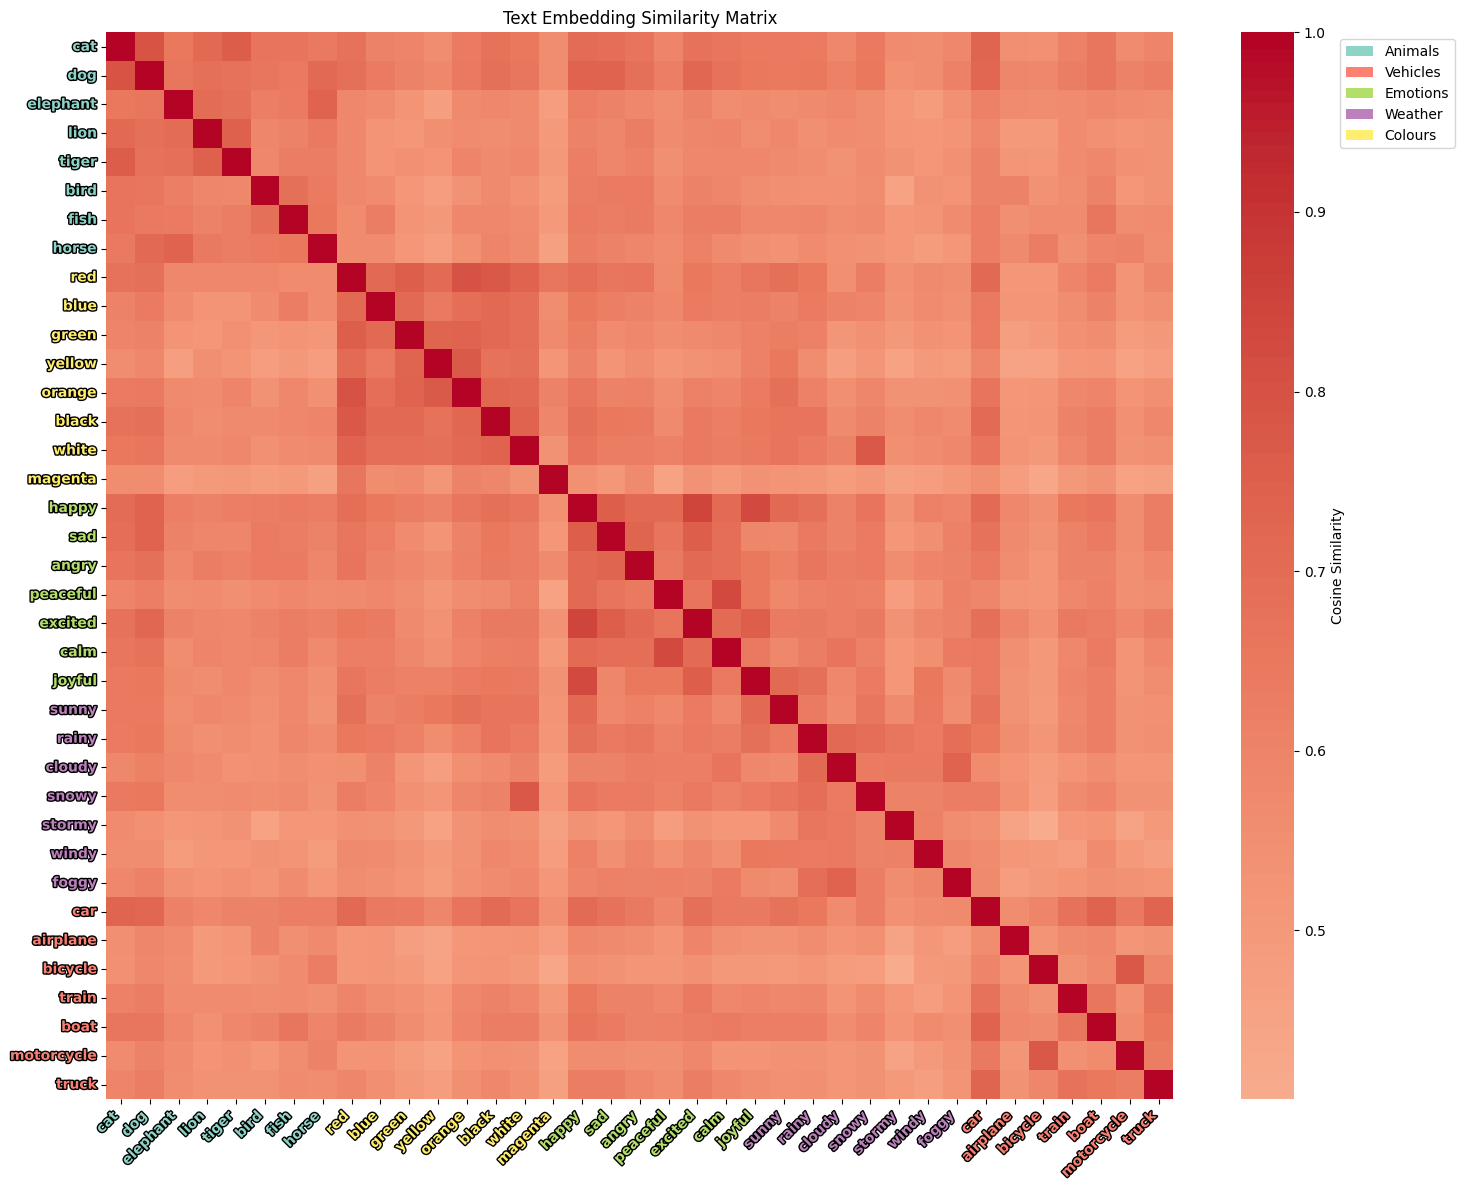

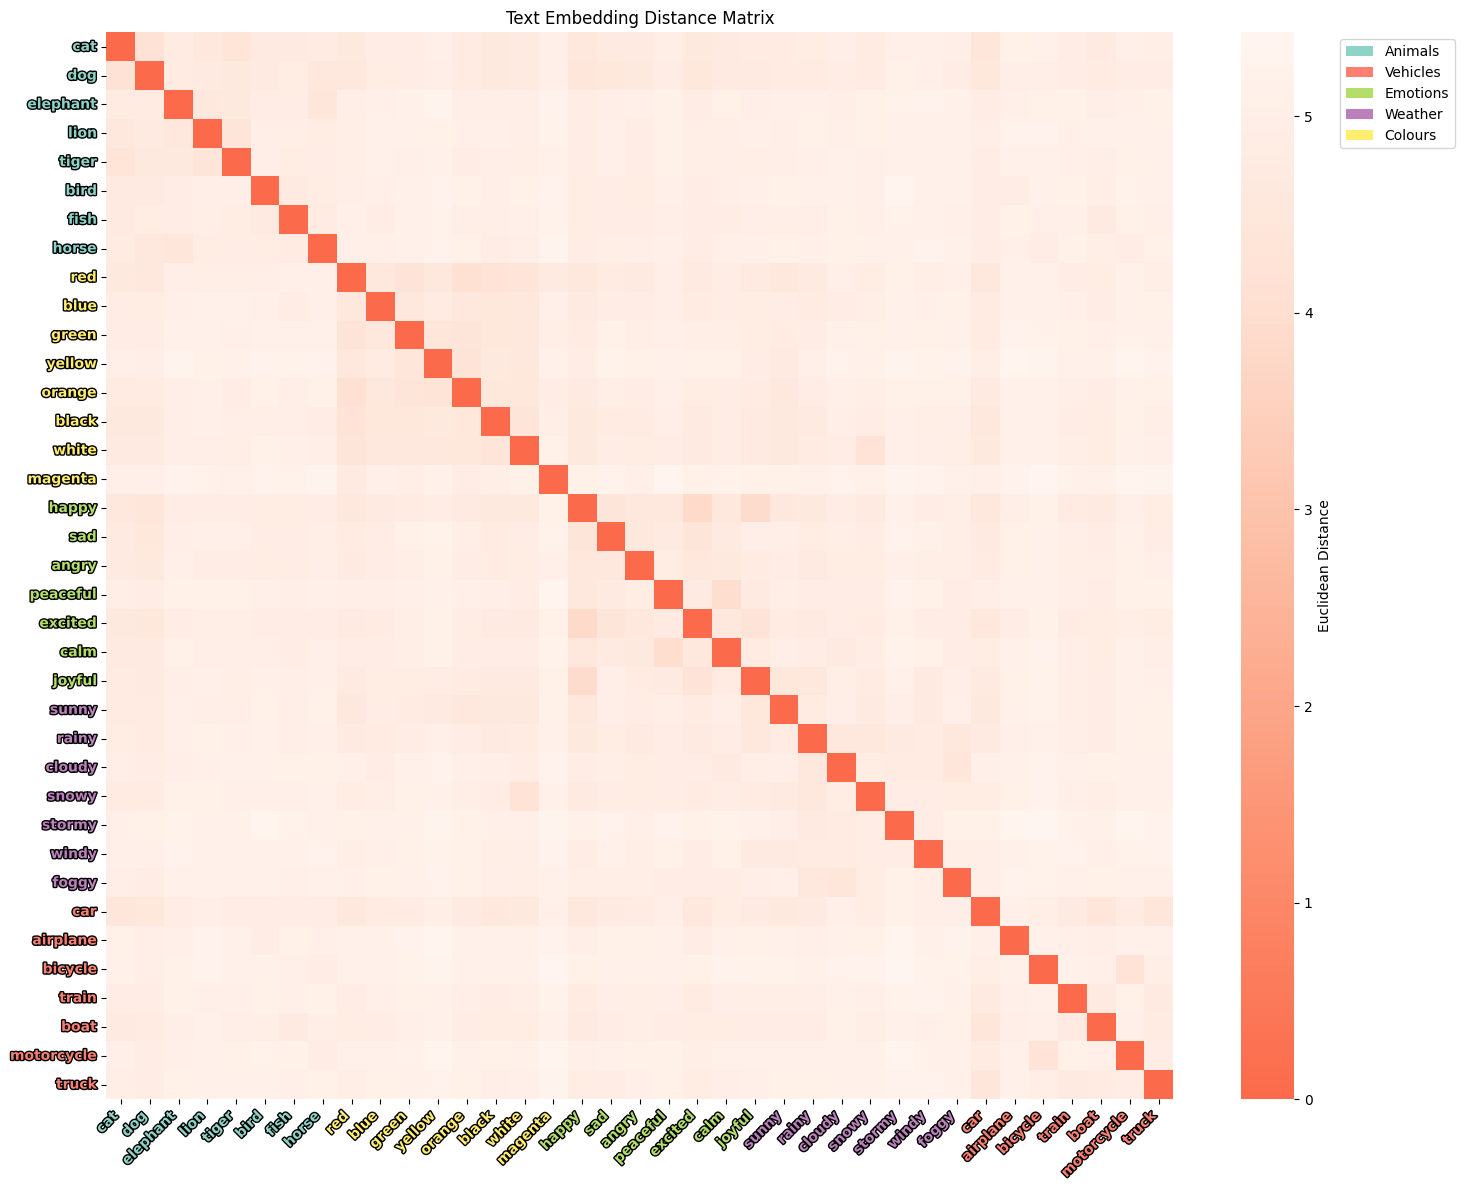

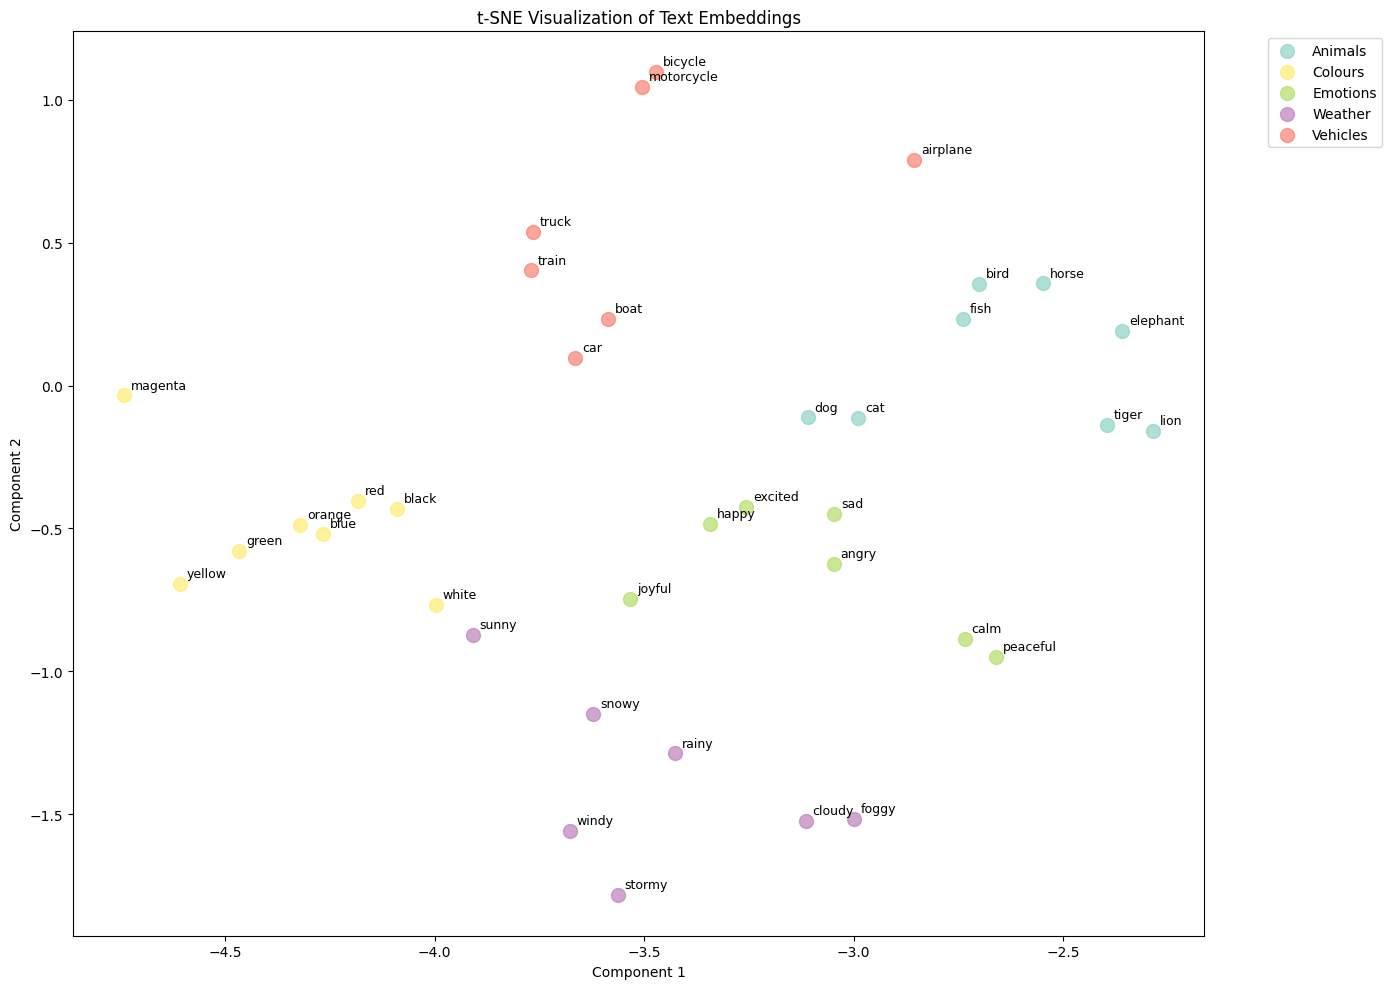

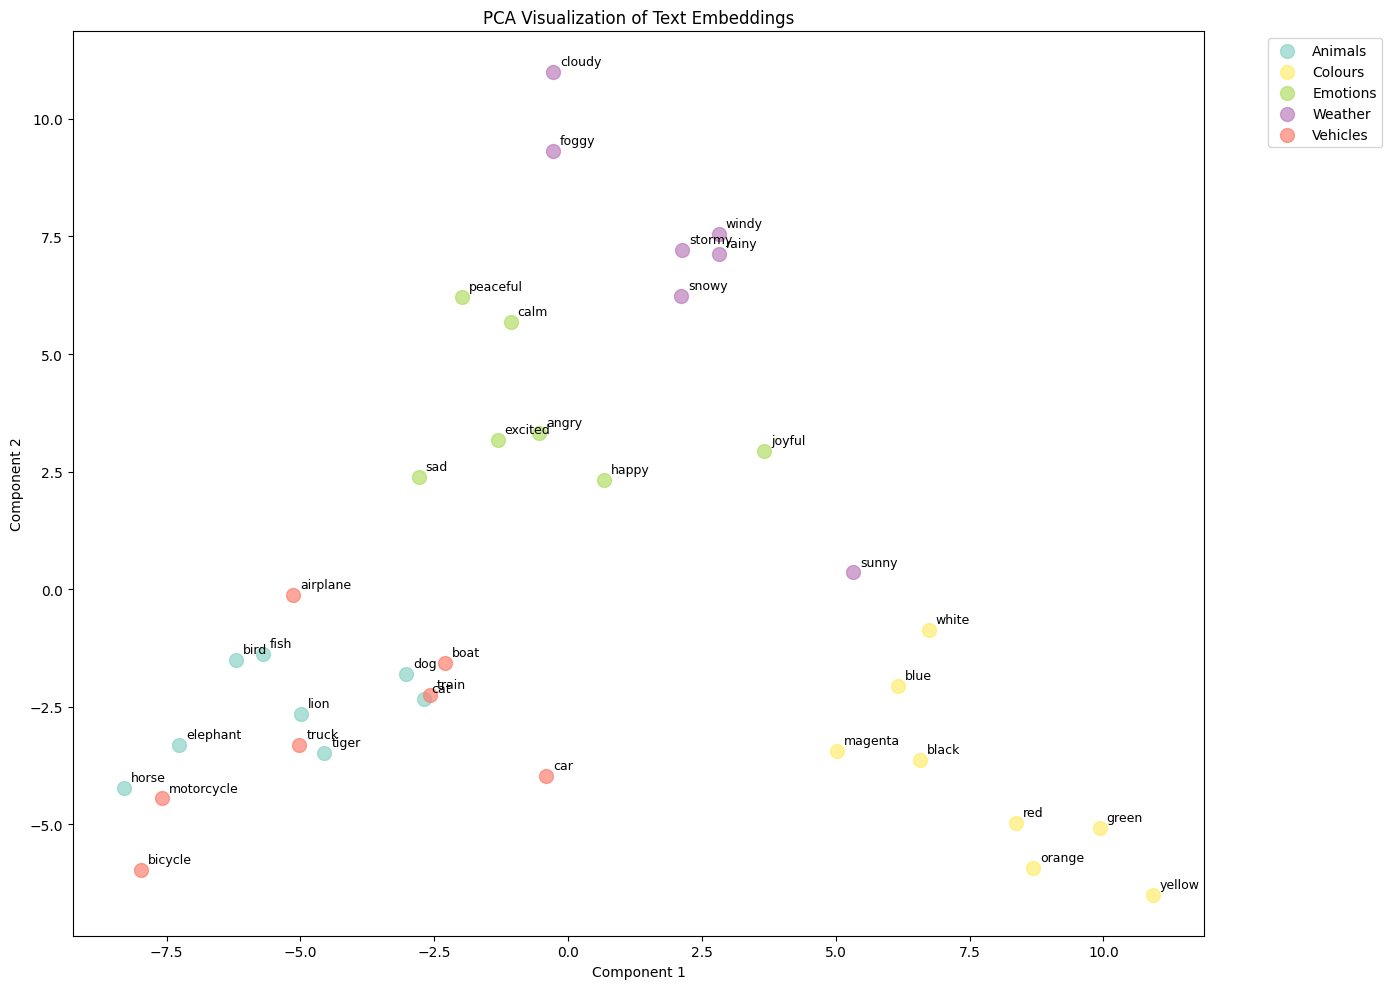


Analysis complete!


In [80]:
# define some concept groups for analysis
concept_groups = {
    'Animals': [
        'cat', 'dog', 'elephant', 'lion', 'tiger', 'bird', 'fish', 'horse'
    ],
    'Colours': [
        'red', 'blue', 'green', 'yellow', 'orange', 'black', 'white', 'magenta'
    ],
    'Emotions': [
        'happy', 'sad', 'angry', 'peaceful', 'excited', 'calm', 'joyful'
    ],
    'Weather': [
        'sunny', 'rainy', 'cloudy', 'snowy', 'stormy', 'windy', 'foggy'
    ],
    'Vehicles': [
        'car', 'airplane', 'bicycle', 'train', 'boat', 'motorcycle', 'truck'
    ]
}

# as an alternative: more complex prompts
complex_concept_groups = {
    'Portrait Styles': [
        'realistic portrait', 'oil painting portrait', 'watercolor portrait',
        'digital art portrait', 'sketch portrait', 'photorealistic portrait'
    ],
    'Landscapes': [
        'mountain landscape', 'ocean landscape', 'forest landscape',
        'desert landscape', 'city landscape', 'rural landscape'
    ],
    'Art Movements': [
        'impressionist style', 'cubist style', 'surrealist style',
        'abstract expressionist style', 'renaissance style', 'baroque style'
    ]
}

if __name__ == "__main__":
    try:
        main(concept_groups, complex_concept_groups)
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have sufficient disk space and internet connection for model download.")

# Now test it on words that have a similar concept, different visual representation
- These are concepts that are similar in meaning, however they are different in visuals e.g. pack vs team

Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded on device: cuda
Analysing concept similarity...
Analyzing 36 concepts across 5 categories...

SIMILARITY ANALYSIS RESULTS

Intra-category similarity (same category):
  Mean: 0.5702
  Std:  0.0713

Inter-category similarity (different categories):
  Mean: 0.5473
  Std:  0.0569

Difference (intra - inter): 0.0229
✓ Good semantic clustering: Similar concepts are more similar than different concepts

Distance Statistics
Intra-category distance (same category):
  Mean: 4.9940
  Std:  0.2185

Inter-category distance (different categories):
  Mean: 5.0636
  Std:  0.1584

Difference (intra - inter): -0.0696

Most similar pair:
  'song' ↔ 'music' (similarity: 0.7966)
  'whiskers' ↔ 'windmill' (distance: 4.1495)

Least similar pair:
  'whiskers' ↔ 'windmill' (similarity: 0.4169)
  'whiskers' ↔ 'windmill' (distance: 5.4100)

Generating visualizations...


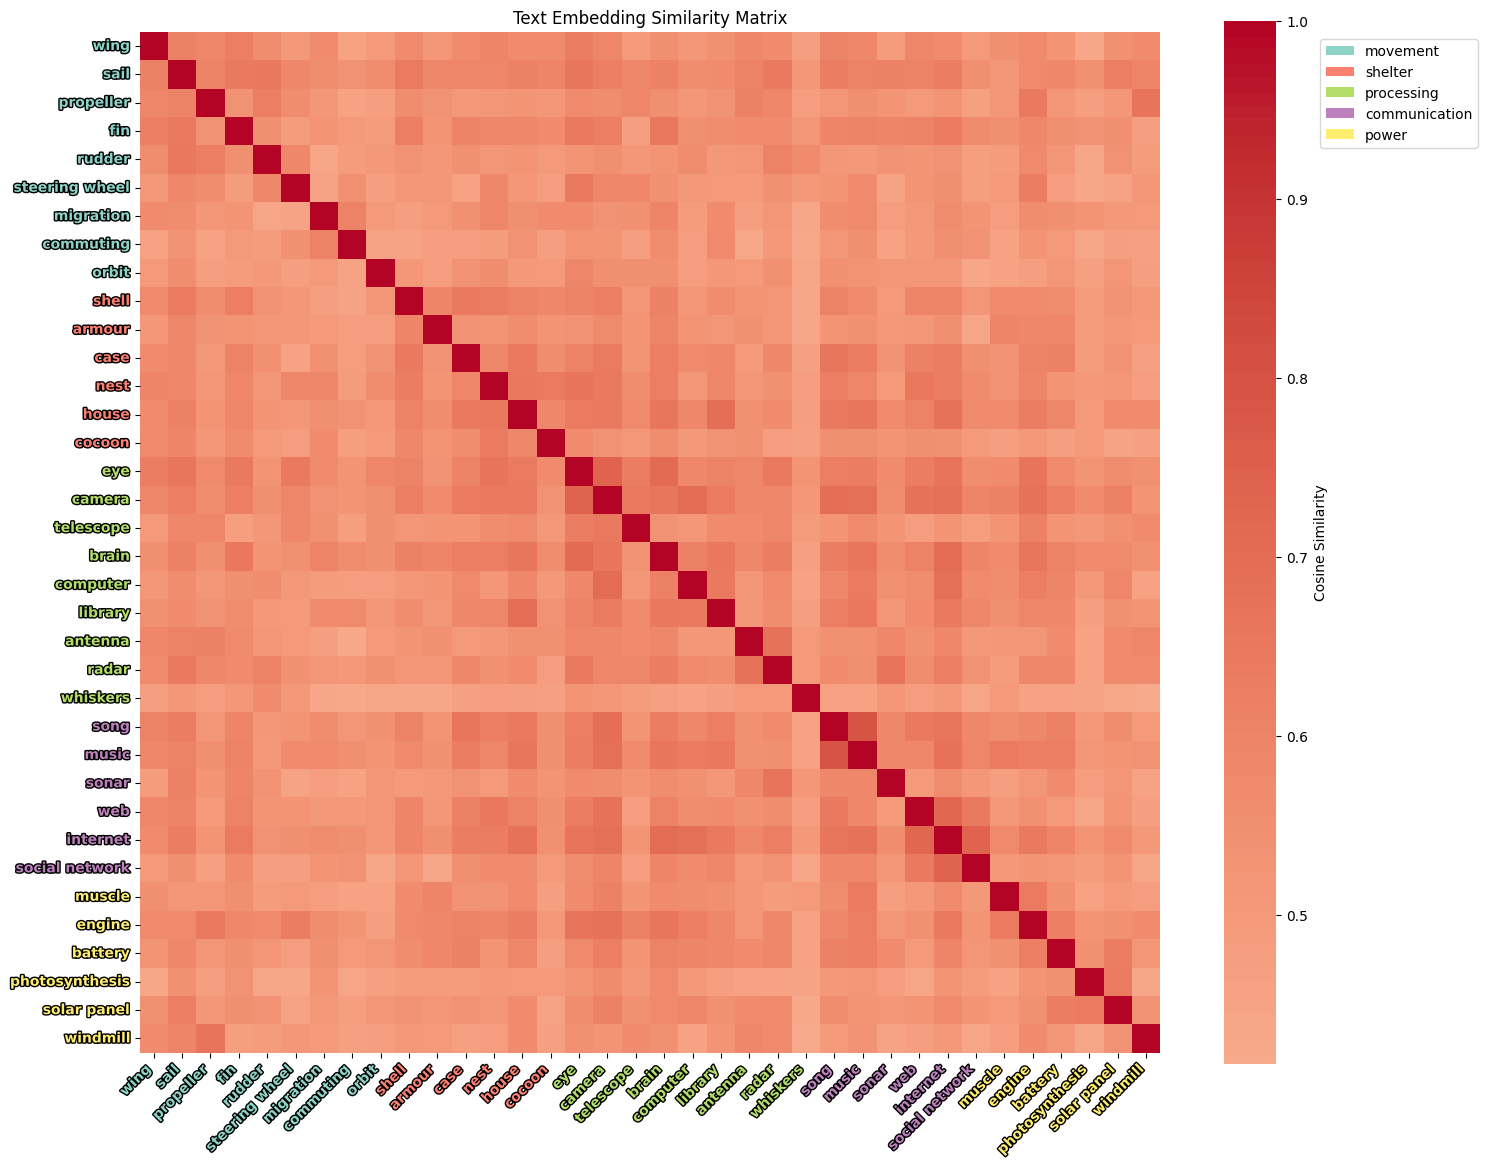

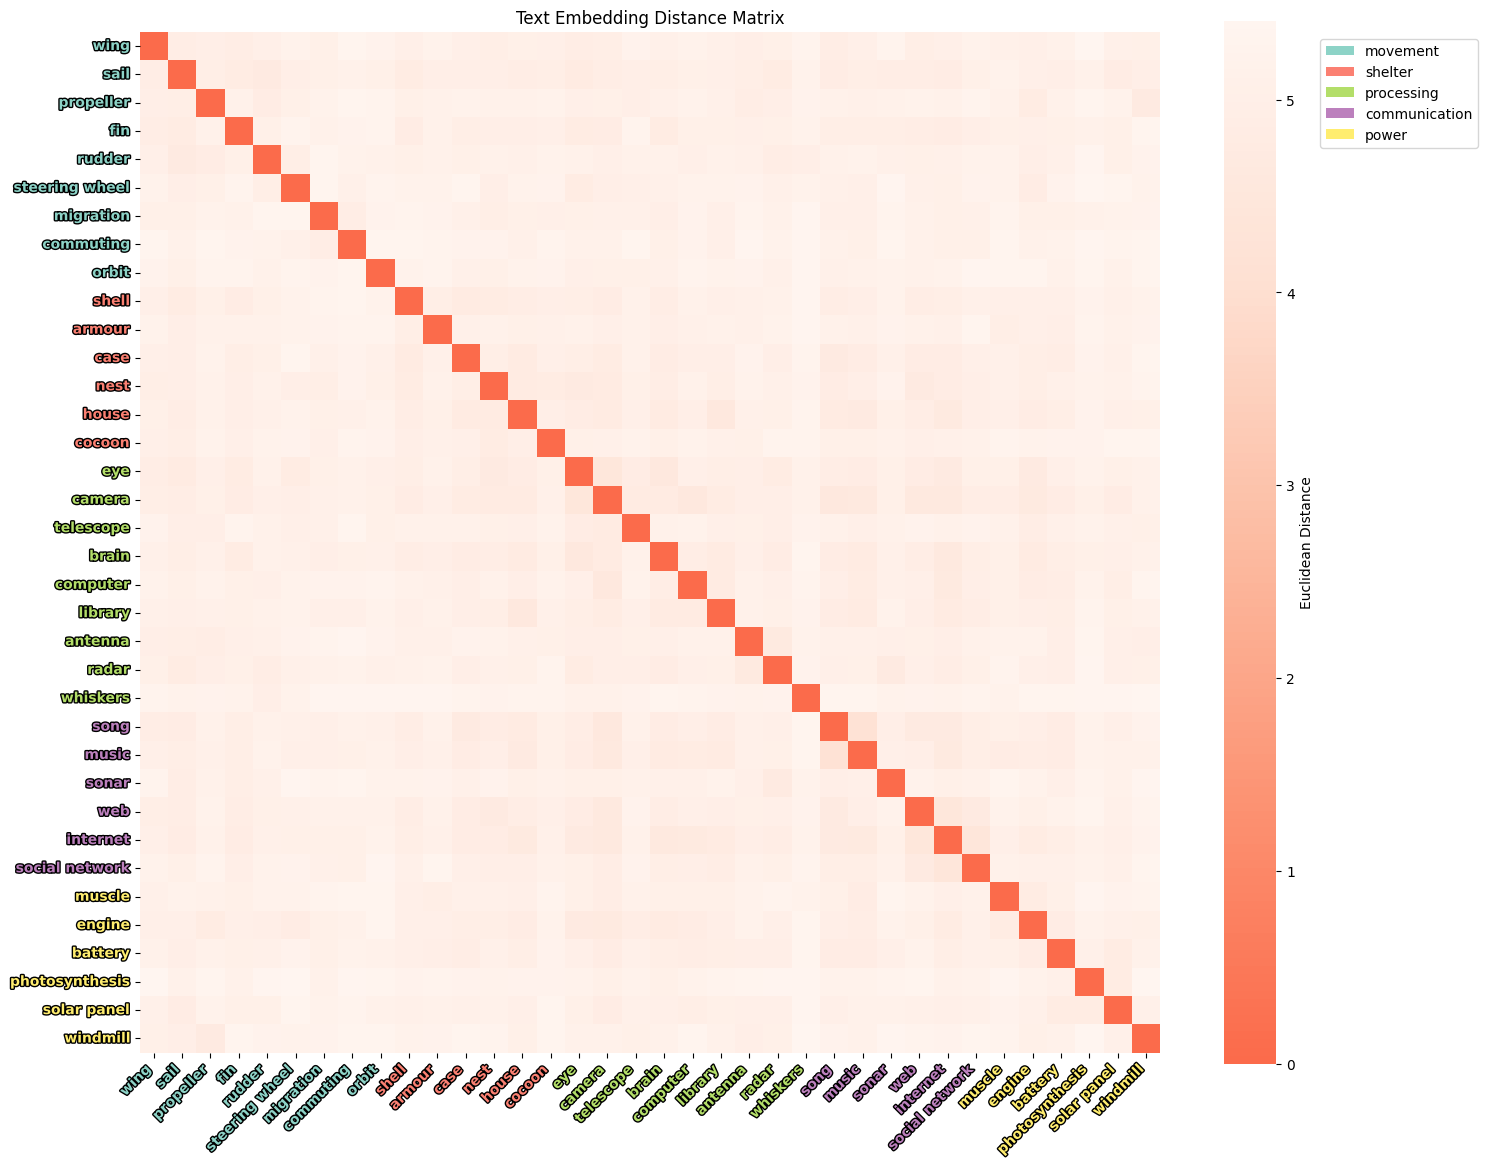

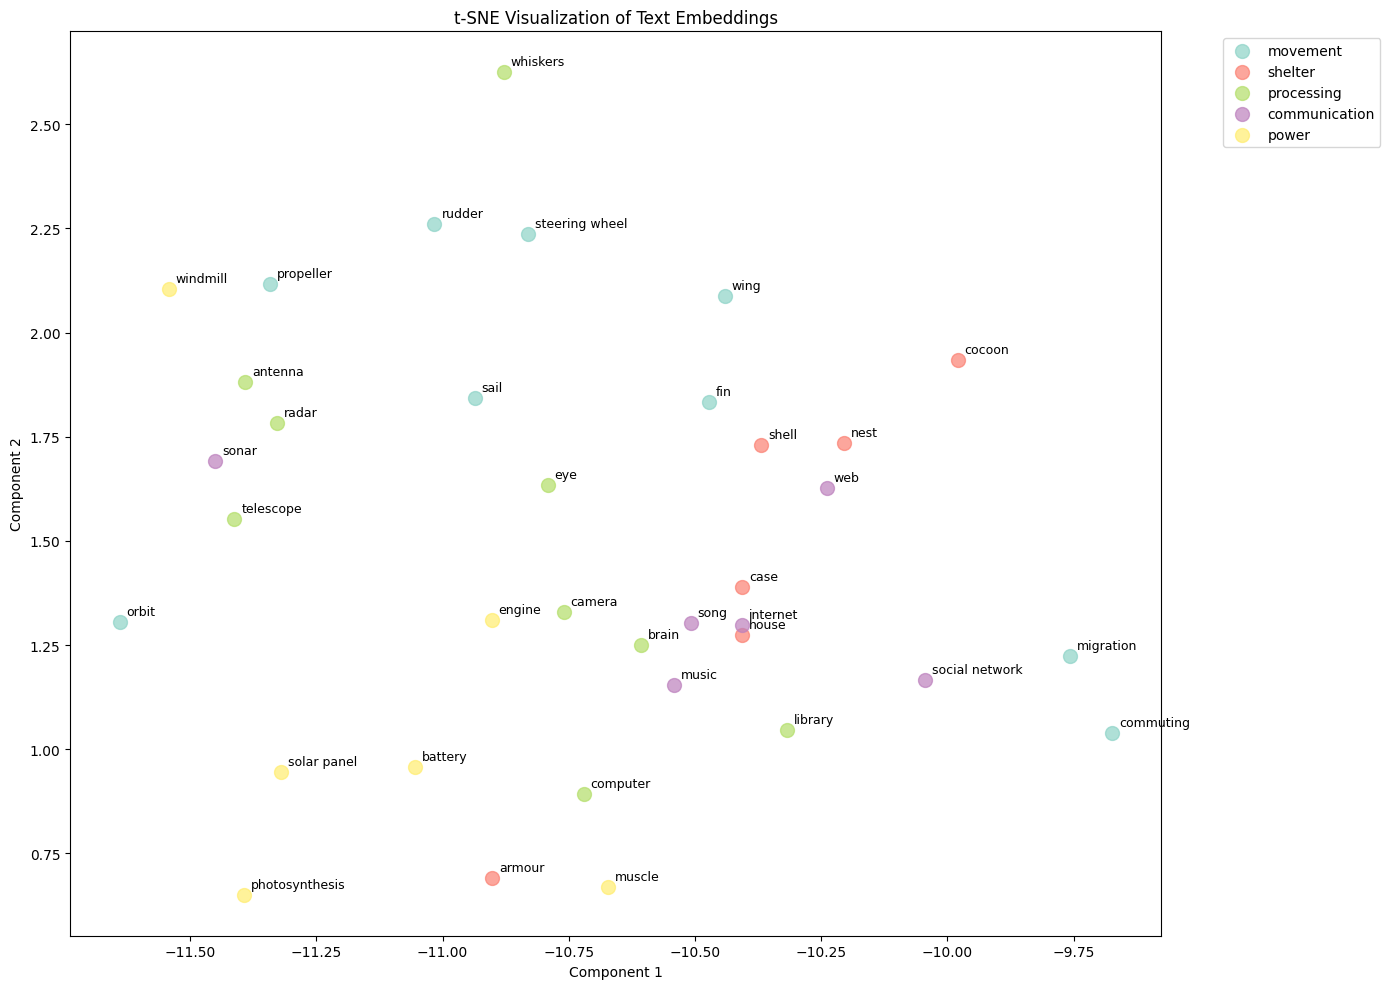

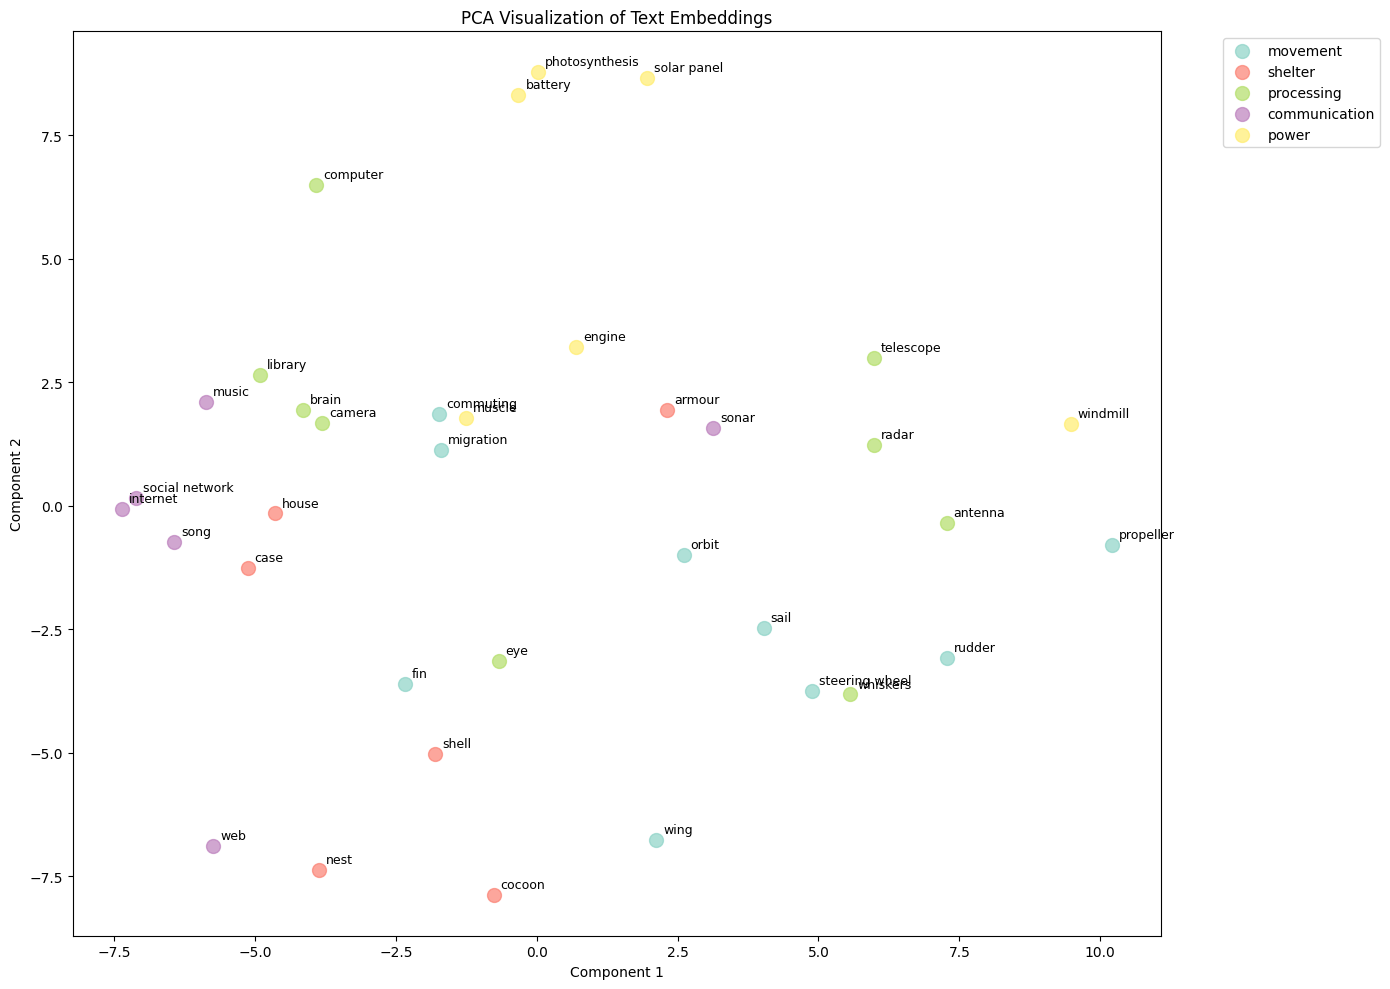


Analysis complete!


In [81]:
# define some concept groups for analysis
concept_groups = {
    'movement': [
        'wing', 'sail', 'propeller',
        'fin', 'rudder', 'steering wheel',
        'migration', 'commuting', 'orbit'
    ],
    'shelter': [
        'shell', 'armour', 'case',
        'nest', 'house', 'cocoon',
        # 'herd', 'formation', 'convoy'
    ],
    'processing': [
        'eye', 'camera', 'telescope',
        'brain', 'computer', 'library', 
        'antenna', 'radar', 'whiskers'
    ],
    'communication': [
        'song', 'music', 'sonar',
        'web', 'internet', 'social network'
    ],
    'power': [
        'muscle', 'engine', 'battery',
        'photosynthesis', 'solar panel', 'windmill'
    ]
}

if __name__ == "__main__":
    try:
        main(concept_groups, complex_concept_groups)
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have sufficient disk space and internet connection for model download.")